# SPATIAL TRANSFORMER NETWORKS TUTORIAL
https://pytorch.org/tutorials/intermediate/spatial_transformer_tutorial.html

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import torchvision as tv
import matplotlib.pyplot as plt
import time
import os
import copy

plt.rcParams['figure.figsize'] = [16,8]
plt.ion()  # interactive mode

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

num_workers = os.cpu_count()
print(num_workers)

# Ignore warnings for image input
import warnings
warnings.filterwarnings("ignore")

cuda:0
6


In [2]:
data_dir = os.path.join('.', 'data')
batch_size = 32

mean = (0.1307,)
std = (0.3081, )

train_dataset = tv.datasets.MNIST(
    root=data_dir,
    train=True,
    download=True,
    transform=tv.transforms.Compose([
        tv.transforms.ToTensor(),
        tv.transforms.Normalize(mean, std)
    ]))
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers)

test_dataset = tv.datasets.MNIST(
    root=data_dir,
    train=False,
    download=True,
    transform=tv.transforms.Compose([
        tv.transforms.ToTensor(),
        tv.transforms.Normalize(mean, std)
    ]))
test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers)

In [3]:
data_iter = iter(train_loader)
images, _ = data_iter.next()
images.size()

torch.Size([32, 1, 28, 28])

In [4]:
p = .5

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)  # out_dim=24**2*10
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)  # pool_out_dim=12**2*10, out_dim=8**2*10 
        self.conv2_drop = nn.Dropout2d(p=p)  # dropout doesn't affect dimension
        self.fc1 = nn.Linear(320, 50)  # pool_out_dim=in_dim=4**2*20=320
        self.fc2 = nn.Linear(50, 10)
        
        # Spatial transformer localization-network
        self.localization = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=7),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True),
            nn.Conv2d(8, 10, kernel_size=5),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True))
        
        # Regressor for the 3 * 2 affine matrix
        self.fc_loc = nn.Sequential(
            nn.Linear(10*3*3, 32),
            nn.ReLU(True),
            nn.Linear(32, 3*2))
        
        # Initialize the weights/bias with identity transformation
        self.fc_loc[2].weight.data.zero_()
        self.fc_loc[2].bias.data.copy_(torch.tensor([1, 0, 0, 0, 1, 0], dtype=torch.float))
        
    def stn(self, x):
        '''Spatial transformer network forward function
        '''
        xs = self.localization(x)
        xs = xs.view(-1, 10*3*3)
        theta = self.fc_loc(xs)
        theta = theta.view(-1, 2, 3)

        grid = F.affine_grid(theta, x.size())
        x = F.grid_sample(x, grid)
        return x
    
    def forward(self, x):
        # transform the input
        x = self.stn(x)

        # Perform the usual forward pass
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [5]:
model = Net().to(device)
print(model)

optimizer = optim.SGD(model.parameters(), lr=0.01)
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

Net(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
  (localization): Sequential(
    (0): Conv2d(1, 8, kernel_size=(7, 7), stride=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU(inplace=True)
    (3): Conv2d(8, 10, kernel_size=(5, 5), stride=(1, 1))
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): ReLU(inplace=True)
  )
  (fc_loc): Sequential(
    (0): Linear(in_features=90, out_features=32, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=32, out_features=6, bias=True)
  )
)


In [6]:
def train():
    start = time.time()
    model.train()
    train_loss = 0
    correct = 0
    
    for batch_idx, (data, target) in enumerate(train_loader):
        data = data.to(device)
        target = target.to(device)
        
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        
        # for display
        train_loss += loss.item() * data.size(0)
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(target.view_as(pred)).sum().item()
        
    train_loss = train_loss / len(train_loader.dataset)
    accuracy = correct/len(train_loader.dataset)
    return train_loss, accuracy

In [7]:
def test():
    with torch.no_grad():
        model.eval()
        test_loss = 0
        correct = 0
        
        for data, target in test_loader:
            data = data.to(device)
            target = target.to(device)
            output = model(data)
            
            test_loss += F.nll_loss(output, target, size_average=False).item()
            pred = output.max(1, keepdim=True)[1]
            correct += pred.eq(target.view_as(pred)).sum().item()
        
        test_loss /= len(test_loader.dataset)
        accuracy = correct/len(test_loader.dataset)
    return test_loss, accuracy

In [8]:
def convert_image_np(inp):
    """Convert a Tensor to numpy image."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    return inp

In [9]:
def visualize_stn():
    with torch.no_grad():
        # Get a batch of training data
        data = next(iter(test_loader))[0].to(device)

        input_tensor = data.cpu()
        transformed_input_tensor = model.stn(data).cpu()

        in_grid = convert_image_np(
            tv.utils.make_grid(input_tensor))

        out_grid = convert_image_np(
            tv.utils.make_grid(transformed_input_tensor))

        # Plot the results side-by-side
        f, axarr = plt.subplots(1, 2)
        axarr[0].imshow(in_grid)
        axarr[0].set_title('Dataset Images')

        axarr[1].imshow(out_grid)
        axarr[1].set_title('Transformed Images')

In [10]:
for epoch in range(20):
    start = time.time()
    train_loss, train_acc = train()
    test_loss, test_acc = test()
    time_elapsed = time.time() - start
    print('Epoch: {} - {:.0f}m {:.1f}s - Train loss:{:.4f}, accuracy: {:.4f} - Test loss:{:.4f}, accuracy: {:.4f}'.format(
        epoch+1,
        time_elapsed//60,
        time_elapsed%60,
        train_loss,
        train_acc,
        test_loss,
        test_acc))

Epoch: 1 - 0m 7.7s - Train loss:0.8598, accuracy: 0.7174 - Test loss:0.1701, accuracy: 0.9520
Epoch: 2 - 0m 7.6s - Train loss:0.3230, accuracy: 0.9059 - Test loss:0.1077, accuracy: 0.9677
Epoch: 3 - 0m 7.6s - Train loss:0.2470, accuracy: 0.9298 - Test loss:0.0839, accuracy: 0.9735
Epoch: 4 - 0m 7.6s - Train loss:0.2010, accuracy: 0.9433 - Test loss:0.0618, accuracy: 0.9807
Epoch: 5 - 0m 7.6s - Train loss:0.1790, accuracy: 0.9495 - Test loss:0.0591, accuracy: 0.9800
Epoch: 6 - 0m 7.7s - Train loss:0.1635, accuracy: 0.9548 - Test loss:0.0455, accuracy: 0.9853
Epoch: 7 - 0m 7.6s - Train loss:0.1494, accuracy: 0.9590 - Test loss:0.0529, accuracy: 0.9819
Epoch: 8 - 0m 7.6s - Train loss:0.1412, accuracy: 0.9623 - Test loss:0.0459, accuracy: 0.9865
Epoch: 9 - 0m 7.6s - Train loss:0.1314, accuracy: 0.9633 - Test loss:0.0450, accuracy: 0.9864
Epoch: 10 - 0m 7.6s - Train loss:0.1302, accuracy: 0.9634 - Test loss:0.0451, accuracy: 0.9862
Epoch: 11 - 0m 7.7s - Train loss:0.1176, accuracy: 0.9678 -

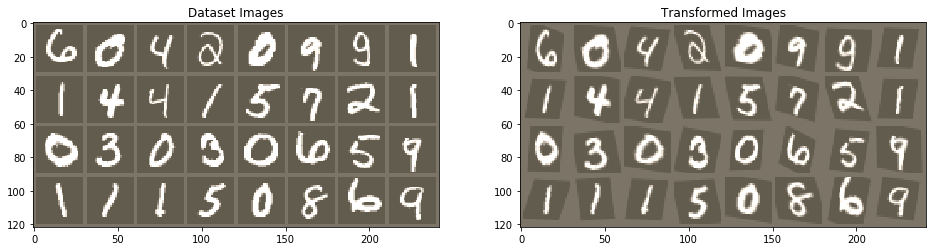

In [11]:
visualize_stn()
plt.ioff()
plt.show()